In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv
import dagshub
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import optuna
from optuna.samplers import TPESampler # bayesian optimizer for the selection of hyperparameters in optuna	
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix
import mlflow
from mlflow.models import infer_signature
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

c:\Users\Yassine\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load environment variables from the .env file
load_dotenv("../.env")

# Set the DagsHub username and token from environment variables
dagshub_username = os.getenv('MLFLOW_TRACKING_USERNAME')
dagshub_token = os.getenv('MLFLOW_TRACKING_PASSWORD')

# Print or assert to confirm the values are loaded
if dagshub_username and dagshub_token:
    print("Environment variables loaded successfully:")
    print("DagsHub Username:", dagshub_username)
    print("DagsHub Token:", "Loaded" if dagshub_token else "Not Loaded")
else:
    print("Failed to load environment variables.")

# Set the MLflow tracking URI to your existing DagsHub repository
mlflow.set_tracking_uri(f"https://dagshub.com/yassine_msaddak/insurance-car-accident-fraud-detection.mlflow")

# Optionally authenticate with your DagsHub credentials
os.environ['MLFLOW_TRACKING_USERNAME'] = dagshub_username
os.environ['MLFLOW_TRACKING_PASSWORD'] = dagshub_token

# Now you can log your model and experiments directly with MLflow
print(f"Using MLflow to track experiments on DagsHub repo: {dagshub_username}/insurance-car-accident-fraud-detection")

Environment variables loaded successfully:
DagsHub Username: yassine_msaddak
DagsHub Token: Loaded
Using MLflow to track experiments on DagsHub repo: yassine_msaddak/insurance-car-accident-fraud-detection


In [3]:
train_path = os.path.join(os.path.dirname("modeling.ipynb"), '..', 'data', 'df_train_1.csv')
test_path = os.path.join(os.path.dirname("modeling.ipynb"), '..', 'data', 'df_test_1.csv')
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

X_train = train.drop(columns=['FraudFound_P'])
y_train = train['FraudFound_P']
X_test = test.drop(columns=['FraudFound_P'])
y_test = test['FraudFound_P']


# Define the paths to the train and test CSV files for unbalanced data
train_path_unbalanced = os.path.join(os.path.dirname("modeling.ipynb"), '..', 'data', 'df_train_1_unbalanced.csv')
test_path_unbalanced = os.path.join(os.path.dirname("modeling.ipynb"), '..', 'data', 'df_test_1_unbalanced.csv')

# Load the train and test datasets
train_unbalanced = pd.read_csv(train_path_unbalanced)
test_unbalanced = pd.read_csv(test_path_unbalanced)

# Prepare the feature matrices (X) and target vectors (y)
X_train_unbalanced = train_unbalanced.drop(columns=['FraudFound_P'])
y_train_unbalanced = train_unbalanced['FraudFound_P']
X_test_unbalanced = test_unbalanced.drop(columns=['FraudFound_P'])
y_test_unbalanced = test_unbalanced['FraudFound_P']

# Logistic Regression

In [6]:
# Create a new MLflow Experiment
mlflow.set_experiment("insurance-fraud-detection-experiment")

params = {'max_iter':1500, 'solver':'liblinear', 'class_weight':'balanced', 'penalty':'l2', 'C':1.0,}
# Initialize the Logistic Regression model with increased max_iter
log_reg = LogisticRegression(**params)

# Train the model
log_reg.fit(X_train, y_train)

# Make predictions on training data
y_train_pred = log_reg.predict(X_train)
y_train_pred_prob = log_reg.predict_proba(X_train)[:, 1]

# Make predictions on test data
y_test_pred = log_reg.predict(X_test)
y_test_pred_prob = log_reg.predict_proba(X_test)[:, 1]

# Evaluate the model on training data
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluate the model on test data
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Metrics:")
print(f"F1 Score: {train_f1}")
print(f"ROC AUC Score: {train_roc_auc}")
print(f"Accuracy: {train_accuracy}")

print("\nTest Metrics:")
print(f"F1 Score: {test_f1}")
print(f"ROC AUC Score: {test_roc_auc}")
print(f"Accuracy: {test_accuracy}")

Training Metrics:
F1 Score: 0.8223158256683573
ROC AUC Score: 0.9016281750091026
Accuracy: 0.8217335058214748

Test Metrics:
F1 Score: 0.15121951219512195
ROC AUC Score: 0.6668837709499322
Accuracy: 0.77431906614786


In [8]:
# Log parameters and metrics with MLflow
mlflow.log_params(params)
mlflow.log_metric("train_accuracy", train_accuracy)
mlflow.log_metric("train_F1_Score", train_f1)
mlflow.log_metric("train_ROC_AUC_Score", train_roc_auc)
mlflow.log_metric("test_accuracy", test_accuracy)
mlflow.log_metric("test_F1_Score", test_f1)
mlflow.log_metric("test_ROC_AUC_Score", test_roc_auc)

# Set a tag for the run
mlflow.set_tag("Training Info", "SVM model training")

# Infer the model signature
signature = infer_signature(X_train, log_reg.predict(X_train))

# Log the model
model_info = mlflow.sklearn.log_model(
    sk_model=log_reg,
    artifact_path="insurance_fraud_model_svm",
    signature=signature,
    input_example=X_train,
    registered_model_name="logistic_regression",
)

c:\Users\Yassine\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'logistic_regression'.
2024/11/27 16:51:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: logistic_regres

# SVM

In [5]:
# Create a new MLflow Experiment
mlflow.set_experiment("insurance-fraud-detection-experiment")

# Parameters for SVM
params = {
    'kernel': 'linear',
    'C':5.4,
    'max_iter': -1,
    'probability': True
}

# Initialize the SVM model with the specified parameters
svm_model = SVC(**params)

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions on training data
y_train_pred = svm_model.predict(X_train)
y_train_pred_prob = svm_model.predict_proba(X_train)[:, 1]

# Make predictions on test data
y_test_pred = svm_model.predict(X_test)
y_test_pred_prob = svm_model.predict_proba(X_test)[:, 1]

# Evaluate the model on training data
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluate the model on test data
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Metrics:")
print(f"F1 Score: {train_f1}")
print(f"ROC AUC Score: {train_roc_auc}")
print(f"Accuracy: {train_accuracy}")

print("\nTest Metrics:")
print(f"F1 Score: {test_f1}")
print(f"ROC AUC Score: {test_roc_auc}")
print(f"Accuracy: {test_accuracy}")

Training Metrics:
F1 Score: 0.8291204986149584
ROC AUC Score: 0.9025878309027705
Accuracy: 0.8297542043984476

Test Metrics:
F1 Score: 0.13648293963254593
ROC AUC Score: 0.6624457554850387
Accuracy: 0.7866407263294423


In [6]:
# Log parameters and metrics with MLflow
mlflow.log_params(params)
mlflow.log_metric("train_accuracy", train_accuracy)
mlflow.log_metric("train_F1_Score", train_f1)
mlflow.log_metric("train_ROC_AUC_Score", train_roc_auc)
mlflow.log_metric("test_accuracy", test_accuracy)
mlflow.log_metric("test_F1_Score", test_f1)
mlflow.log_metric("test_ROC_AUC_Score", test_roc_auc)

# Set a tag for the run
mlflow.set_tag("Training Info", "SVM model training")

# Infer the model signature
signature = infer_signature(X_train, svm_model.predict(X_train))

# Log the model
model_info = mlflow.sklearn.log_model(
    sk_model=svm_model,
    artifact_path="insurance_fraud_model_svm",
    signature=signature,
    input_example=X_train,
    registered_model_name="SVM",
)

c:\Users\Yassine\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'SVM'.
2024/11/27 20:30:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SVM, version 1
Created version 

# KNN

In [8]:
# Create a new MLflow Experiment
mlflow.set_experiment("insurance-fraud-detection-experiment")

# Parameters for KNN
params = {
    'n_neighbors': 2,
    'p': 3
}

# Initialize the KNN model with the specified parameters
knn_model = KNeighborsClassifier(**params)

# Train the model
knn_model.fit(X_train, y_train)

# Make predictions on training data
y_train_pred = knn_model.predict(X_train)
y_train_pred_prob = knn_model.predict_proba(X_train)[:, 1]

# Make predictions on test data
y_test_pred = knn_model.predict(X_test)
y_test_pred_prob = knn_model.predict_proba(X_test)[:, 1]

# Evaluate the model on training data
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluate the model on test data
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Metrics:")
print(f"F1 Score: {train_f1}")
print(f"ROC AUC Score: {train_roc_auc}")
print(f"Accuracy: {train_accuracy}")

print("\nTest Metrics:")
print(f"F1 Score: {test_f1}")
print(f"ROC AUC Score: {test_roc_auc}")
print(f"Accuracy: {test_accuracy}")

Training Metrics:
F1 Score: 0.9947979885555748
ROC AUC Score: 0.9988485914405537
Accuracy: 0.9948253557567918

Test Metrics:
F1 Score: 0.12041884816753927
ROC AUC Score: 0.5606819094069265
Accuracy: 0.7821011673151751


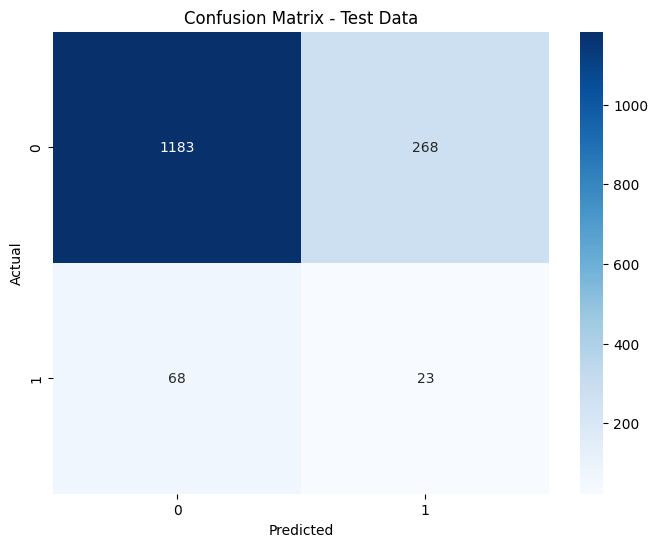

In [9]:
# Plot confusion matrix for test data
train_cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Log parameters and metrics with MLflow
mlflow.log_params(params)
mlflow.log_metric("train_accuracy", train_accuracy)
mlflow.log_metric("train_F1_Score", train_f1)
mlflow.log_metric("train_ROC_AUC_Score", train_roc_auc)
mlflow.log_metric("test_accuracy", test_accuracy)
mlflow.log_metric("test_F1_Score", test_f1)
mlflow.log_metric("test_ROC_AUC_Score", test_roc_auc)

# Set a tag for the run
mlflow.set_tag("Training Info", "KNN model training")

# Infer the model signature
signature = infer_signature(X_train, knn_model.predict(X_train))

# Log the model
model_info = mlflow.sklearn.log_model(
    sk_model=knn_model,
    artifact_path="insurance_fraud_model_knn",
    signature=signature,
    input_example=X_train,
    registered_model_name="KNN",
)

# Random Forest

In [11]:
# Create a new MLflow Experiment
mlflow.set_experiment("insurance-fraud-detection-experiment")

# Parameters for Random Forest
params = {
    'n_estimators': 129,  # Number of trees in the forest
    'max_depth': 4  # Minimum number of samples required to be at a leaf node
}

# Initialize the Random Forest model with the specified parameters
rf_model = RandomForestClassifier(**params)

# Create a pipeline with scaling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', rf_model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions on training data
y_train_pred = pipeline.predict(X_train)
y_train_pred_prob = pipeline.predict_proba(X_train)[:, 1]

# Make predictions on test data
y_test_pred = pipeline.predict(X_test)
y_test_pred_prob = pipeline.predict_proba(X_test)[:, 1]

# Evaluate the model on training data
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluate the model on test data
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Metrics:")
print(f"F1 Score: {train_f1}")
print(f"ROC AUC Score: {train_roc_auc}")
print(f"Accuracy: {train_accuracy}")

print("\nTest Metrics:")
print(f"F1 Score: {test_f1}")
print(f"ROC AUC Score: {test_roc_auc}")
print(f"Accuracy: {test_accuracy}")

Training Metrics:
F1 Score: 0.8294640749193358
ROC AUC Score: 0.9048201205283768
Accuracy: 0.813109098749461

Test Metrics:
F1 Score: 0.20714285714285716
ROC AUC Score: 0.7590710461144644
Accuracy: 0.7120622568093385


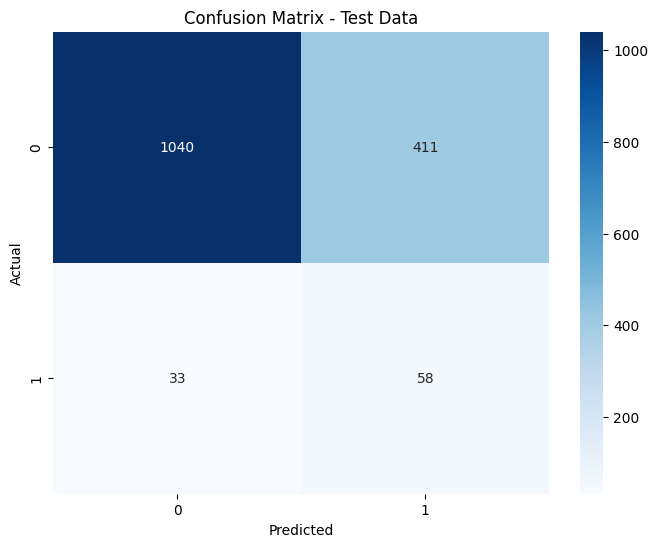

In [12]:
# Plot confusion matrix for test data
train_cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [13]:
# Log parameters and metrics with MLflow
mlflow.log_params(params)
mlflow.log_metric("train_accuracy", train_accuracy)
mlflow.log_metric("train_F1_Score", train_f1)
mlflow.log_metric("train_ROC_AUC_Score", train_roc_auc)
mlflow.log_metric("test_accuracy", test_accuracy)
mlflow.log_metric("test_F1_Score", test_f1)
mlflow.log_metric("test_ROC_AUC_Score", test_roc_auc)

# Set a tag for the run
mlflow.set_tag("Training Info", "Random Forest model training")

# Infer the model signature
signature = infer_signature(X_train, rf_model.predict(X_train))

# Log the model
model_info = mlflow.sklearn.log_model(
    sk_model=rf_model,
    artifact_path="insurance_fraud_model_rf",
    signature=signature,
    input_example=X_train,
    registered_model_name="RandomForest",
)

c:\Users\Yassine\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\Yassine\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Regist

# Optuna with Random Forest, KNN, SVM, Logistic Regression

In [17]:
def objective(trial):
    classifier_name = trial.suggest_categorical('classifier', ['SVM', 'RandomForest', 'KNN', 'LogisticRegression'])
    
    if classifier_name == 'SVM':
        C = trial.suggest_float('svm_C', 0.1, 10.0)
        kernel = trial.suggest_categorical('svm_kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        # Initialize SVC with L2 regularization (default)
        classifier_obj = SVC(C=C, kernel=kernel, probability=True, random_state=42)
    
    elif classifier_name == 'RandomForest':
        n_estimators = trial.suggest_int('rf_n_estimators', 50, 300)
        max_depth = trial.suggest_int('rf_max_depth', 3, 40)
        classifier_obj = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    
    elif classifier_name == 'KNN':
        n_neighbors = trial.suggest_int('knn_n_neighbors', 3, 20)
        weights = trial.suggest_categorical('knn_weights', ['uniform', 'distance'])
        classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
    
    elif classifier_name == 'LogisticRegression':
        C = trial.suggest_float('lr_C', 0.1, 10.0)
        # Define valid (penalty, solver) pairs
        lr_options = [
            {'penalty': 'l1', 'solver': 'liblinear'},
            {'penalty': 'l1', 'solver': 'saga'},
            {'penalty': 'l2', 'solver': 'lbfgs'},
            {'penalty': 'l2', 'solver': 'liblinear'},
            {'penalty': 'l2', 'solver': 'sag'},
            {'penalty': 'l2', 'solver': 'saga'},
            {'penalty': 'l2', 'solver': 'newton-cg'}
        ]
        lr_option = trial.suggest_categorical('lr_option', lr_options)
        penalty = lr_option['penalty']
        solver = lr_option['solver']
        
        classifier_obj = LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver,
            max_iter=1000,  # Increased to ensure convergence
            random_state=42
        )
    
    # Create a pipeline with scaling
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', classifier_obj)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict probabilities
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    # Threshold optimization for F1 Score
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_threshold = 0.5
    best_f1 = 0.0
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        score = f1_score(y_test, y_pred)
        if score > best_f1:
            best_f1 = score
            best_threshold = threshold
    
    # Optionally, you can also log other metrics or attributes
    trial.set_user_attr('best_threshold', best_threshold)
    trial.set_user_attr('classifier_obj', pipeline)
    
    return best_f1  # Optimize for the best F1 score

# Create and run the Optuna study
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=200)

# Display the best trial
print("Best trial:")

[I 2024-11-27 23:57:17,849] A new study created in memory with name: no-name-b63499ae-48a4-4b0a-8346-b62d79679ca6
[I 2024-11-27 23:57:18,738] Trial 0 finished with value: 0.20926756352765322 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 62, 'rf_max_depth': 11}. Best is trial 0 with value: 0.20926756352765322.
[I 2024-11-27 23:57:19,812] Trial 1 finished with value: 0.21592442645074225 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 77, 'rf_max_depth': 7}. Best is trial 1 with value: 0.21592442645074225.
[I 2024-11-27 23:57:22,126] Trial 2 finished with value: 0.2029769959404601 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 135, 'rf_max_depth': 36}. Best is trial 1 with value: 0.21592442645074225.
[I 2024-11-27 23:57:22,480] Trial 3 finished with value: 0.16 and parameters: {'classifier': 'KNN', 'knn_n_neighbors': 13, 'knn_weights': 'uniform'}. Best is trial 1 with value: 0.21592442645074225.
[I 2024-11-27 23:57:22,854] Trial 4 f

Best trial:


In [18]:
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

  Value: 0.2347266881028939
  Params: 
    classifier: RandomForest
    rf_n_estimators: 129
    rf_max_depth: 4


In [10]:
best_trial = study.best_trial
print('Best trial: ', best_trial.values)
print('Best hyperparameters: ', best_trial.params)

Best trial:  [0.23248407643312102]
Best hyperparameters:  {'classifier': 'RandomForest', 'rf_n_estimators': 135, 'rf_max_depth': 4}


# LightGBM

In [38]:
# Set up the MLflow experiment
mlflow.set_experiment("insurance-fraud-detection-experiment")

params = {
    'num_leaves': 34,
    'learning_rate': 0.29879542894273386,
    'n_estimators': 228
}

# Initialize the LightGBM model with the specified parameters
lgb_model = lgb.LGBMClassifier(**params)

# Create a pipeline with scaling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', lgb_model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions on training data
y_train_pred = pipeline.predict(X_train)
y_train_pred_prob = pipeline.predict_proba(X_train)[:, 1]

# Make predictions on test data
y_test_pred = pipeline.predict(X_test)
y_test_pred_prob = pipeline.predict_proba(X_test)[:, 1]

# Evaluate the model on training data
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluate the model on test data
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Metrics:")
print(f"F1 Score: {train_f1}")
print(f"ROC AUC Score: {train_roc_auc}")
print(f"Accuracy: {train_accuracy}")

print("\nTest Metrics:")
print(f"F1 Score: {test_f1}")
print(f"ROC AUC Score: {test_roc_auc}")
print(f"Accuracy: {test_accuracy}")

[LightGBM] [Info] Number of positive: 5797, number of negative: 5798
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 11595, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499957 -> initscore=-0.000172
[LightGBM] [Info] Start training from score -0.000172
Training Metrics:
F1 Score: 0.9996551129505087
ROC AUC Score: 0.9999999107435226
Accuracy: 0.9996550237171195

Test Metrics:
F1 Score: 0.16113744075829384
ROC AUC Score: 0.724365916647102
Accuracy: 0.8852140077821011


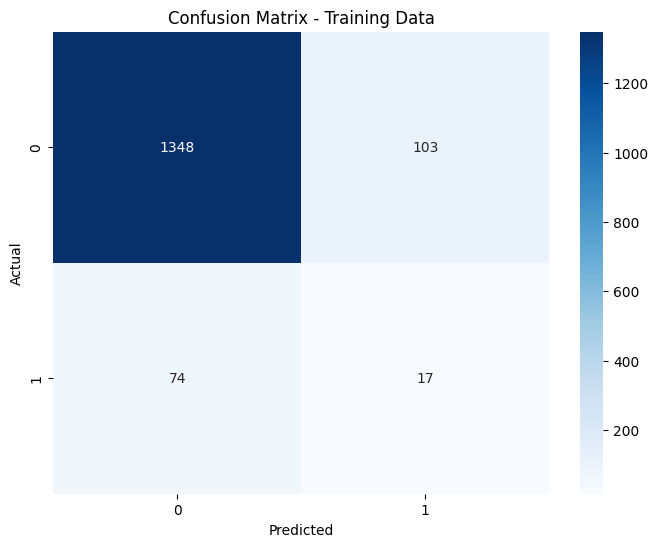

In [18]:
# Plot confusion matrix for test data
train_cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Training Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Lightgbm on unbalanced data

In [11]:
# Create a new MLflow Experiment
mlflow.set_experiment("insurance-fraud-detection-experiment")

params = {
    'boosting_type': 'gbdt',
    'num_leaves': 32,
    'learning_rate': 0.01,
    'n_estimators': 150
}

# Initialize the LightGBM model with the specified parameters
lgb_model = lgb.LGBMClassifier(**params)

# Train the model
lgb_model.fit(X_train_unbalanced, y_train_unbalanced)

# Make predictions on training data
y_train_pred = lgb_model.predict(X_train_unbalanced)
y_train_pred_prob = lgb_model.predict_proba(X_train_unbalanced)[:, 1]

# Make predictions on test data
y_test_pred = lgb_model.predict(X_test_unbalanced)
y_test_pred_prob = lgb_model.predict_proba(X_test_unbalanced)[:, 1]

# Evaluate the model on training data
train_f1 = f1_score(y_train_unbalanced, y_train_pred)
train_roc_auc = roc_auc_score(y_train_unbalanced, y_train_pred_prob)
train_accuracy = accuracy_score(y_train_unbalanced, y_train_pred)

# Evaluate the model on test data
test_f1 = f1_score(y_test_unbalanced, y_test_pred)
test_roc_auc = roc_auc_score(y_test_unbalanced, y_test_pred_prob)
test_accuracy = accuracy_score(y_test_unbalanced, y_test_pred)

print("Training Metrics:")
print(f"F1 Score: {train_f1}")
print(f"ROC AUC Score: {train_roc_auc}")
print(f"Accuracy: {train_accuracy}")

print("\nTest Metrics:")
print(f"F1 Score: {test_f1}")
print(f"ROC AUC Score: {test_roc_auc}")
print(f"Accuracy: {test_accuracy}")

[LightGBM] [Info] Number of positive: 370, number of negative: 5798
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 156
[LightGBM] [Info] Number of data points in the train set: 6168, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.059987 -> initscore=-2.751765
[LightGBM] [Info] Start training from score -2.751765
Training Metrics:
F1 Score: 0.06266318537859007
ROC AUC Score: 0.9394495305930284
Accuracy: 0.9417963683527886

Test Metrics:
F1 Score: 0.021739130434782608
ROC AUC Score: 0.8212941434857356
Accuracy: 0.9416342412451362


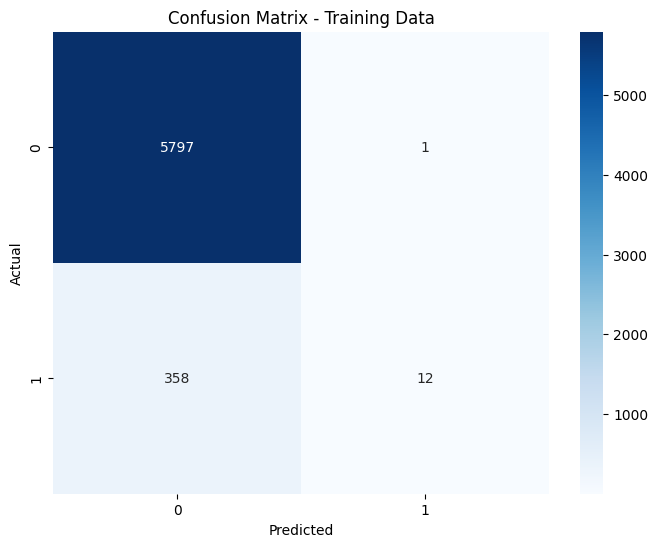

In [12]:
# Plot confusion matrix for training data
train_cm = confusion_matrix(y_train_unbalanced, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Training Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [9]:
# Log parameters and metrics with MLflow
mlflow.log_params(params)
mlflow.log_metric("train_accuracy", train_accuracy)
mlflow.log_metric("train_F1 Score", train_f1)
mlflow.log_metric("train_ROC AUC Score", train_roc_auc)
mlflow.log_metric("test_accuracy", test_accuracy)
mlflow.log_metric("test_F1 Score", test_f1)
mlflow.log_metric("test_ROC AUC Score", test_roc_auc)

# Set a tag for the run
mlflow.set_tag("Training Info", "LightGBM model training")

# Infer the model signature
signature = infer_signature(X_train, lgb_model.predict(X_train))

# Log the model
model_info = mlflow.lightgbm.log_model(
    lgb_model,
    artifact_path="insurance_fraud_model_lgb",
    signature=signature,
    input_example=X_train,
    registered_model_name="LightGBM",
)

c:\Users\Yassine\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LightGBM' already exists. Creating a new version of this model...
2024/11/27 22:26:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creati

# XGBoost on balanced data

In [17]:
# Parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 100,
}

# Initialize the XGBoost model with the specified parameters
xgb_model = xgb.XGBClassifier(**params)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on training data
y_train_pred = xgb_model.predict(X_train)
y_train_pred_prob = xgb_model.predict_proba(X_train)[:, 1]

# Make predictions on test data
y_test_pred = xgb_model.predict(X_test)
y_test_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model on training data
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluate the model on test data
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Metrics:")
print(f"F1 Score: {train_f1}")
print(f"ROC AUC Score: {train_roc_auc}")
print(f"Accuracy: {train_accuracy}")

print("\nTest Metrics:")
print(f"F1 Score: {test_f1}")
print(f"ROC AUC Score: {test_roc_auc}")
print(f"Accuracy: {test_accuracy}")

Training Metrics:
F1 Score: 0.9131463332206826
ROC AUC Score: 0.9699593787820573
Accuracy: 0.9113410952996982

Test Metrics:
F1 Score: 0.16718266253869968
ROC AUC Score: 0.7518800978483955
Accuracy: 0.8255512321660181


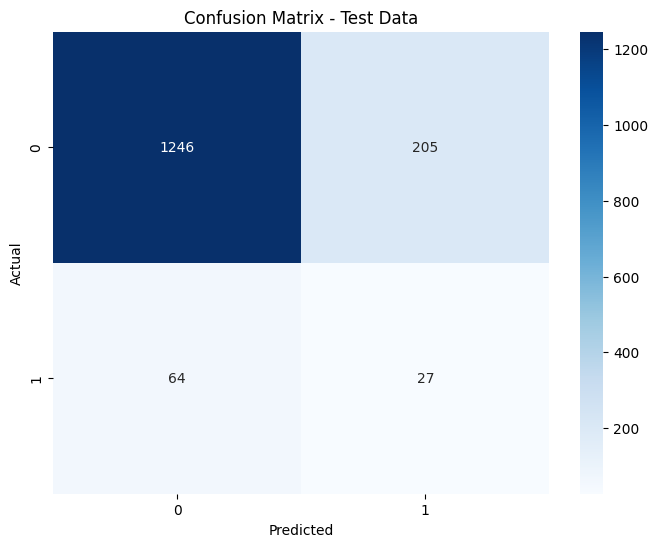

In [18]:
# Plot confusion matrix for test data
train_cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Modeling with Optuna
 - Optuna is an advanced hyperparameter optimization framework designed to streamline the tuning process in machine learning. It employs a Bayesian optimization approach, focusing on efficiency and automation by sampling hyperparameters intelligently based on past results. Unlike traditional methods like GridSearch, which exhaustively evaluates all parameter combinations, Optuna uses a more flexible and adaptive approach with its define-by-run API. This allows it to explore the hyperparameter space dynamically, saving computation time and resources. Additionally, Optuna supports pruning, which terminates underperforming trials early to focus on promising ones. While GridSearch is simple and systematic, making it easier to implement for smaller datasets or straightforward models, Optuna is more suitable for complex problems with large search spaces, where efficiency and scalability are crucial.

## Optuna framework on unbalanced data with boosting models

In [9]:
def objective(trial):
    classifier_name = trial.suggest_categorical('classifier', ['XGBoost', 'LightGBM', 'CatBoost'])
    
    if classifier_name == 'XGBoost':
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        n_estimators = trial.suggest_int('n_estimators', 25, 200)
        classifier_obj = xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            learning_rate=learning_rate,
            max_depth=max_depth,
            n_estimators=n_estimators)
    
    elif classifier_name == 'LightGBM':
        num_leaves = trial.suggest_int('lgb_num_leaves', 20, 70)
        learning_rate = trial.suggest_float('lgb_learning_rate', 0.01, 0.3)
        n_estimators = trial.suggest_int('lgb_n_estimators', 25, 200)
        classifier_obj = lgb.LGBMClassifier(num_leaves=num_leaves, n_estimators=n_estimators, verbose=-1)
    
    elif classifier_name == 'CatBoost':
        iterations = trial.suggest_int('cat_iterations', 50, 300)
        learning_rate = trial.suggest_float('cat_learning_rate', 0.01, 0.3)
        depth = trial.suggest_int('cat_depth', 2, 15)
        classifier_obj = CatBoostClassifier(iterations=iterations, depth=depth, verbose=0)
    
    # Create a pipeline with scaling
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', classifier_obj)
    ])
    
    pipeline.fit(X_train, y_train)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
# Threshold optimization
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_threshold = 0.5
    best_score = 0.0
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        score = f1_score(y_test, y_pred)
        if score > best_score:
            best_score = score
            best_threshold = threshold
    
    trial.set_user_attr('best_threshold', best_threshold)
    trial.set_user_attr('classifier_obj', pipeline)
    return best_score  # Return the best F1 score

In [10]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=200)

[I 2024-11-27 21:57:02,749] A new study created in memory with name: no-name-41c73d7a-48c3-4071-8448-e296fc804580
[I 2024-11-27 21:57:03,118] Trial 0 finished with value: 0.20491803278688525 and parameters: {'classifier': 'LightGBM', 'lgb_num_leaves': 34, 'lgb_learning_rate': 0.13184463637827956, 'lgb_n_estimators': 40}. Best is trial 0 with value: 0.20491803278688525.
[I 2024-11-27 21:57:04,003] Trial 1 finished with value: 0.20933521923620935 and parameters: {'classifier': 'XGBoost', 'learning_rate': 0.05232249651232572, 'max_depth': 7, 'n_estimators': 175}. Best is trial 1 with value: 0.20933521923620935.
[I 2024-11-27 21:57:04,351] Trial 2 finished with value: 0.19830028328611898 and parameters: {'classifier': 'XGBoost', 'learning_rate': 0.1946551435721687, 'max_depth': 7, 'n_estimators': 42}. Best is trial 1 with value: 0.20933521923620935.
[I 2024-11-27 21:57:05,010] Trial 3 finished with value: 0.20434782608695654 and parameters: {'classifier': 'XGBoost', 'learning_rate': 0.2563

In [11]:
best_trial = study.best_trial
print('Best trial: ', best_trial.values)
print('Best hyperparameters: ', best_trial.params)

Best trial:  [0.22764227642276422]
Best hyperparameters:  {'classifier': 'LightGBM', 'lgb_num_leaves': 62, 'lgb_learning_rate': 0.11506698059483247, 'lgb_n_estimators': 181}


In [28]:
# Create a new MLflow Experiment
mlflow.set_experiment("insurance-fraud-detection-experiment")

# Parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.05578888950793298,
    'max_depth': 3,
    'n_estimators': 112,
}

# Initialize the XGBoost model with the specified parameters
xgb_model = xgb.XGBClassifier(**params)

# Train the model
xgb_model.fit(X_train_unbalanced, y_train_unbalanced)

# Make predictions on training data
y_train_pred = xgb_model.predict(X_train_unbalanced)
y_train_pred_prob = xgb_model.predict_proba(X_train_unbalanced)[:, 1]

# Make predictions on test data
y_test_pred = xgb_model.predict(X_test_unbalanced)
y_test_pred_prob = xgb_model.predict_proba(X_test_unbalanced)[:, 1]

# Evaluate the model on training data
train_f1 = f1_score(y_train_unbalanced, y_train_pred)
train_roc_auc = roc_auc_score(y_train_unbalanced, y_train_pred_prob)
train_accuracy = accuracy_score(y_train_unbalanced, y_train_pred)

# Evaluate the model on test data
test_f1 = f1_score(y_test_unbalanced, y_test_pred)
test_roc_auc = roc_auc_score(y_test_unbalanced, y_test_pred_prob)
test_accuracy = accuracy_score(y_test_unbalanced, y_test_pred)

print("Training Metrics:")
print(f"F1 Score: {train_f1}")
print(f"ROC AUC Score: {train_roc_auc}")
print(f"Accuracy: {train_accuracy}")

print("\nTest Metrics:")
print(f"F1 Score: {test_f1}")
print(f"ROC AUC Score: {test_roc_auc}")
print(f"Accuracy: {test_accuracy}")

Training Metrics:
F1 Score: 0.082687338501292
ROC AUC Score: 0.8558988187911953
Accuracy: 0.9424448767833982

Test Metrics:
F1 Score: 0.021739130434782608
ROC AUC Score: 0.8342257329162913
Accuracy: 0.9416342412451362


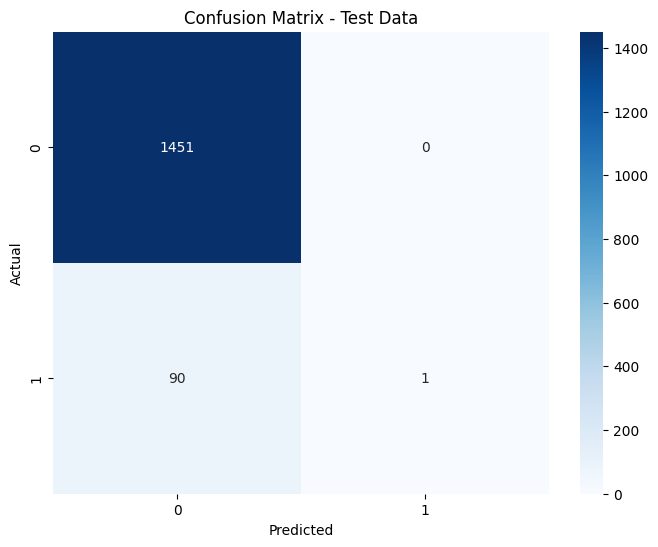

In [29]:
# Plot confusion matrix for test data
train_cm = confusion_matrix(y_test_unbalanced, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Optuna with balanced data on boosting models

In [14]:
def objective(trial):
    classifier_name = trial.suggest_categorical('classifier', ['XGBoost', 'LightGBM', 'CatBoost'])
    
    if classifier_name == 'XGBoost':
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        max_depth = trial.suggest_int('max_depth', 3, 40)
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        classifier_obj = xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            learning_rate=learning_rate,
            max_depth=max_depth,
            n_estimators=n_estimators,
        )
    
    elif classifier_name == 'LightGBM':
        num_leaves = trial.suggest_int('lgb_num_leaves', 20, 70)
        learning_rate = trial.suggest_float('lgb_learning_rate', 0.01, 0.3)
        n_estimators = trial.suggest_int('lgb_n_estimators', 50, 300)
        classifier_obj = lgb.LGBMClassifier(num_leaves=num_leaves, n_estimators=n_estimators, verbose=-1)
    
    elif classifier_name == 'CatBoost':
        iterations = trial.suggest_int('cat_iterations', 20, 300)
        learning_rate = trial.suggest_float('cat_learning_rate', 0.01, 0.3)
        depth = trial.suggest_int('cat_depth', 3, 15)
        classifier_obj = CatBoostClassifier(iterations=iterations, depth=depth, verbose=0)
    
   # Create a pipeline with scaling
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', classifier_obj)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict probabilities
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    # Threshold optimization for F1 Score
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_threshold = 0.5
    best_f1 = 0.0
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        score = f1_score(y_test, y_pred)
        if score > best_f1:
            best_f1 = score
            best_threshold = threshold
    
    # Optionally, you can also log other metrics or attributes
    trial.set_user_attr('best_threshold', best_threshold)
    trial.set_user_attr('classifier_obj', pipeline)
    
    return best_f1  # Optimize for the best F1 score

In [15]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=100)

[I 2024-11-28 00:28:15,682] A new study created in memory with name: no-name-d3908a9c-c540-45e3-905e-27fd51a67ca4
[I 2024-11-28 00:28:16,697] Trial 0 finished with value: 0.20408163265306123 and parameters: {'classifier': 'LightGBM', 'lgb_num_leaves': 63, 'lgb_learning_rate': 0.27834744259549615, 'lgb_n_estimators': 132}. Best is trial 0 with value: 0.20408163265306123.
[I 2024-11-28 00:28:41,727] Trial 1 finished with value: 0.19023136246786632 and parameters: {'classifier': 'CatBoost', 'cat_iterations': 161, 'cat_learning_rate': 0.1032605250951558, 'cat_depth': 12}. Best is trial 0 with value: 0.20408163265306123.
[I 2024-11-28 00:28:43,144] Trial 2 finished with value: 0.19646365422396855 and parameters: {'classifier': 'XGBoost', 'learning_rate': 0.05386256260835953, 'max_depth': 19, 'n_estimators': 111}. Best is trial 0 with value: 0.20408163265306123.
[I 2024-11-28 00:28:44,131] Trial 3 finished with value: 0.19534883720930232 and parameters: {'classifier': 'XGBoost', 'learning_ra

In [16]:
best_trial = study.best_trial
print('Best trial: ', best_trial.values)
print('Best hyperparameters: ', best_trial.params)

Best trial:  [0.21717171717171718]
Best hyperparameters:  {'classifier': 'LightGBM', 'lgb_num_leaves': 34, 'lgb_learning_rate': 0.29879542894273386, 'lgb_n_estimators': 228}


In [24]:
# Create a new MLflow Experiment
mlflow.set_experiment("insurance-fraud-detection-experiment")

params = {
    'num_leaves': 34,
    'learning_rate': 0.298,
    'n_estimators': 34
}

# Initialize the LightGBM model with the specified parameters
lgb_model = lgb.LGBMClassifier(**params)

# Create a pipeline with scaling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', lgb_model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions on training data
y_train_pred = pipeline.predict(X_train)
y_train_pred_prob = pipeline.predict_proba(X_train)[:, 1]

# Make predictions on test data
y_test_pred = pipeline.predict(X_test)
y_test_pred_prob = pipeline.predict_proba(X_test)[:, 1]

# Evaluate the model on training data
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluate the model on test data
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Metrics:")
print(f"F1 Score: {train_f1}")
print(f"ROC AUC Score: {train_roc_auc}")
print(f"Accuracy: {train_accuracy}")

print("\nTest Metrics:")
print(f"F1 Score: {test_f1}")
print(f"ROC AUC Score: {test_roc_auc}")
print(f"Accuracy: {test_accuracy}")

[LightGBM] [Info] Number of positive: 5797, number of negative: 5798
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 11595, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499957 -> initscore=-0.000172
[LightGBM] [Info] Start training from score -0.000172
Training Metrics:
F1 Score: 0.9483920498165999
ROC AUC Score: 0.9878513752310776
Accuracy: 0.9478223372143165

Test Metrics:
F1 Score: 0.1328125
ROC AUC Score: 0.7538794768291667
Accuracy: 0.8560311284046692


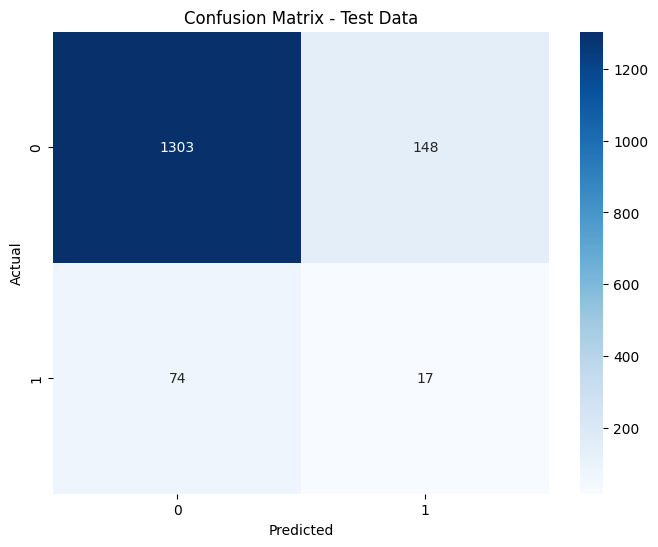

In [25]:
# Plot confusion matrix for test data
train_cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [39]:
# Log parameters and metrics with MLflow
mlflow.log_params(params)
mlflow.log_metric("train_accuracy", train_accuracy)
mlflow.log_metric("train_F1 Score", train_f1)
mlflow.log_metric("train_ROC AUC Score", train_roc_auc)
mlflow.log_metric("test_accuracy", test_accuracy)
mlflow.log_metric("test_F1 Score", test_f1)
mlflow.log_metric("test_ROC AUC Score", test_roc_auc)

# Set a tag for the run
mlflow.set_tag("Training Info", "LightGBM model training")

# Infer the model signature
signature = infer_signature(X_train, lgb_model.predict(X_train))

# Log the model
model_info = mlflow.lightgbm.log_model(
    lgb_model,
    artifact_path="insurance_fraud_model_lgb",
    signature=signature,
    input_example=X_train,
    registered_model_name="LightGBM",
)

c:\Users\Yassine\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LightGBM' already exists. Creating a new version of this model...
2024/11/28 00:50:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creati